# Capstone Project - Brain Tumor MRI Dataset

## Brain Tumor Classifier

### What is a brain tumor?
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.

### The importance of the subject
Early detection and classification of brain tumors is an important research domain in the field of medical imaging and accordingly helps in selecting the most convenient treatment method to save patients life therefore

### Methods
The application of deep learning approaches in context to improve health diagnosis is providing impactful solutions. According to the World Health Organization (WHO), proper brain tumor diagnosis involves detection, brain tumor location identification, and classification of the tumor on the basis of malignancy, grade, and type. This experimental work in the diagnosis of brain tumors using Magnetic Resonance Imaging (MRI) involves detecting the tumor, classifying the tumor in terms of grade, type, and identification of tumor location. This method has experimented in terms of utilizing one model for classifying brain MRI on different classification tasks rather than an individual model for each classification task. The Convolutional Neural Network (CNN) based multi-task classification is equipped for the classification and detection of tumors. The identification of brain tumor location is also done using a CNN-based model by segmenting the brain tumor.

### Objective:
We will use transfer learning to predict the type of a brain tumor based on MRI scans and deploy the model for testing.

The dataset can be found here: https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset

## 1. Import libraries

In [48]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import re
from tqdm import tqdm

from PIL import Image, ImageEnhance
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Input, Conv2D, Dense, Dropout, Dropout, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical, img_to_array
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## 2. Reading the Data

In [2]:
train_dir = 'C:/Users/cloud/Downloads/Institute of Data/Capstone Project/Brain Tumor MRI Dataset/Training/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [3]:
Fseries = pd.Series(train_paths, name="train_paths")
Lseries = pd.Series(train_labels, name="labels")

tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
tumor_df

,train_paths,labels
0,C:/Users/cloud/Downloads/Institute of Data/Cap...,meningioma
1,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
2,C:/Users/cloud/Downloads/Institute of Data/Cap...,pituitary
3,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
4,C:/Users/cloud/Downloads/Institute of Data/Cap...,pituitary
...,...,...
5707,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
5708,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
5709,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
5710,C:/Users/cloud/Downloads/Institute of Data/Cap...,meningioma


In [4]:
print(tumor_df["labels"].value_counts())
print(tumor_df.shape)

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: labels, dtype: int64
(5712, 2)


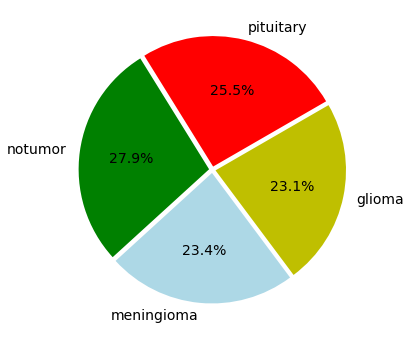

In [5]:
plt.figure(figsize=(14,6))
colors = ['r', 'g', 'lightblue', 'y']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30);

Text(0.5, 1.02, 'Count of images per class')

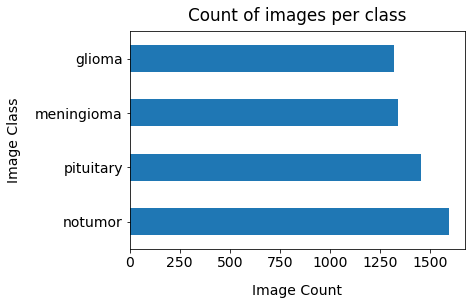

In [6]:
tumor_df['labels'].value_counts().plot.barh(x = 'labels', y = 'count')

plt.xlabel("Image Count", labelpad=14)
plt.ylabel("Image Class", labelpad=14)
plt.title("Count of images per class", y=1.02)

#### The training dataset is quite well balanced.

In [7]:
test_dir = 'C:/Users/cloud/Downloads/Institute of Data/Capstone Project/Brain Tumor MRI Dataset/Testing/'

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [8]:
Fseries1 = pd.Series(test_paths, name="test_paths")
Lseries1 = pd.Series(test_labels, name="labels")

tumor_test = pd.concat([Fseries1,Lseries1], axis=1)
tumor_testdf = pd.DataFrame(tumor_test)
tumor_testdf

,test_paths,labels
0,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
1,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
2,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
3,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
4,C:/Users/cloud/Downloads/Institute of Data/Cap...,notumor
...,...,...
1306,C:/Users/cloud/Downloads/Institute of Data/Cap...,meningioma
1307,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
1308,C:/Users/cloud/Downloads/Institute of Data/Cap...,glioma
1309,C:/Users/cloud/Downloads/Institute of Data/Cap...,pituitary


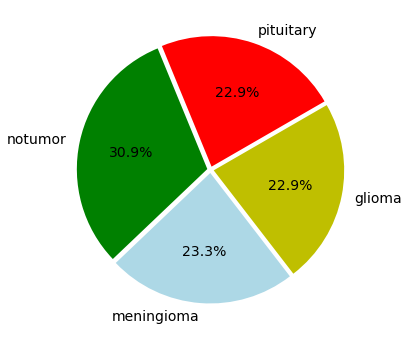

In [9]:
plt.figure(figsize=(14,6))
colors = ['r', 'g', 'lightblue', 'y']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in test_labels if x=='pituitary']),
         len([x for x in test_labels if x=='notumor']),
         len([x for x in test_labels if x=='meningioma']),
         len([x for x in test_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30);

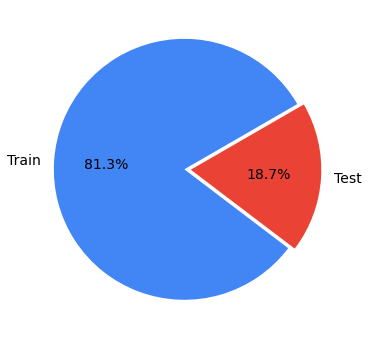

In [10]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

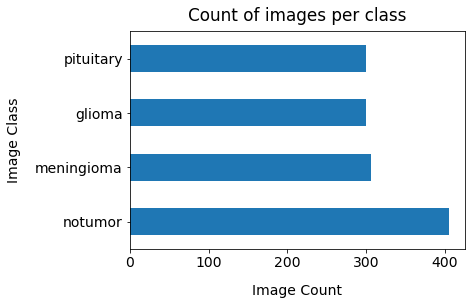

In [11]:
tumor_testdf['labels'].value_counts().plot.barh(x = 'labels', y = 'count')

plt.xlabel("Image Count", labelpad=14)
plt.ylabel("Image Class", labelpad=14)
plt.title("Count of images per class", y=1.02);

## 3. Data Augmentation

- Random Brightness: 80% - 120%
- Random Contrast: 80% - 120%

In [12]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image)/255.0
    return image

### Let's plot some samples.

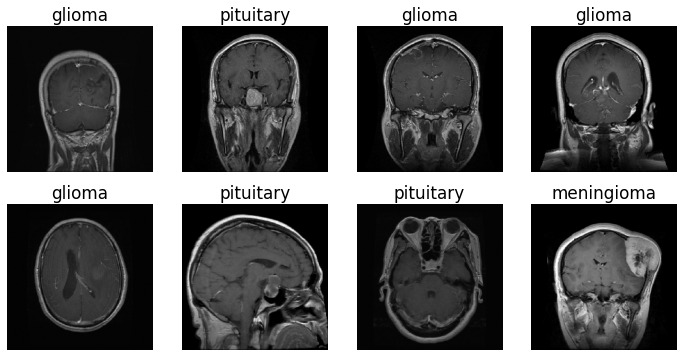

In [13]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(224, 224))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [14]:
def get_labels(paths):
    '''
    it is possible to get the label from the path, just split the path by "/" and index -2
    For example, /kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1020.jpg
    splitting by "/" gives ['kaggle','input','brain-tumor-mri-dataset','Training','pituitary','Tr-pi_1020.jpg']
    Now indexing -2 gives "pituitary"
    '''
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

meningioma


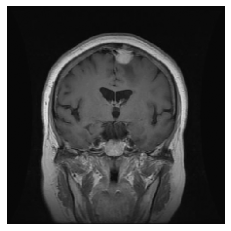

In [15]:
i = random.randint(0,len(train_paths))
label = train_paths[i].split('/')[-2] # This is how we get the label from the path, train_paths[i]
image = open_images([train_paths[i]])
print(label)
plt.imshow(image[0])
plt.axis('off')
plt.show()

In [16]:
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

## 4. Data Generation

In [17]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

#### VGG16

In [95]:
vgg16_layer = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in vgg16_layer.layers:
    layer.trainable = False
# Set the last vgg block to trainable
vgg16_layer.layers[-2].trainable = True
vgg16_layer.layers[-3].trainable = True
vgg16_layer.layers[-4].trainable = True

model_vgg16 = Sequential()
model_vgg16.add(Input(shape=(224, 224, 3)))
model_vgg16.add(vgg16_layer)
model_vgg16.add(Flatten())
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dropout(0.2))
model_vgg16.add(Dense(4, activation='softmax'))

In [96]:
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 10,291,332


In [97]:
model_vgg16.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])

### Train Model

In [99]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history_vgg16 = model_vgg16.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 361s 1s/step - loss: 0.3747 - sparse_categorical_accuracy: 0.8623
Epoch 2/4
285/285 [==============================] - 366s 1s/step - loss: 0.1729 - sparse_categorical_accuracy: 0.9348
Epoch 3/4
285/285 [==============================] - 362s 1s/step - loss: 0.0976 - sparse_categorical_accuracy: 0.9642
Epoch 4/4
285/285 [==============================] - 364s 1s/step - loss: 0.0762 - sparse_categorical_accuracy: 0.9719


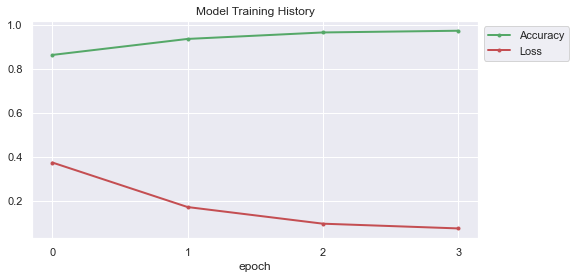

In [100]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_vgg16.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_vgg16.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Evaluate Model with Test Samples

1/1 [==============================] - 0s 76ms/step
Predicted: glioma
Actual: glioma


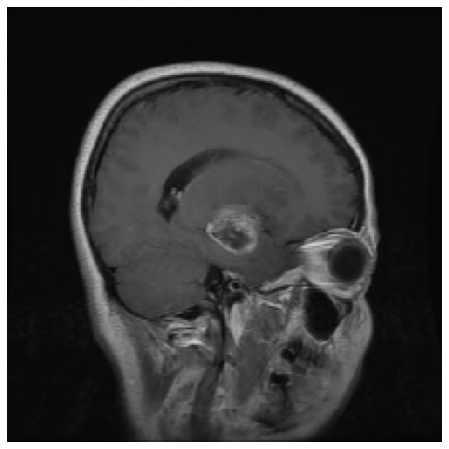

In [137]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted_vgg16 = model_vgg16.predict(images)[0]
predicted_vgg16 = np.argmax(predicted_vgg16)
predicted_vgg16 = labels[predicted_vgg16]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
plt.axis('off')
print('Predicted:', predicted_vgg16)
print('Actual:', label)

In [138]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_vgg16 = []
y_true = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_vgg16 = model_vgg16.predict(x)
    pred_vgg16 = np.argmax(pred_vgg16, axis=-1)
    for i in decode_label(pred_vgg16):
        y_pred_vgg16.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|██                                                                                 | 1/40 [00:01<01:06,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|████▏                                                                              | 2/40 [00:03<01:04,  1.70s/it]

1/1 [==============================] - 2s 2s/step


  8%|██████▏                                                                            | 3/40 [00:05<01:03,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 10%|████████▎                                                                          | 4/40 [00:06<01:01,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 12%|██████████▍                                                                        | 5/40 [00:08<00:59,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 15%|████████████▍                                                                      | 6/40 [00:10<00:58,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 18%|██████████████▌                                                                    | 7/40 [00:12<00:57,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 20%|████████████████▌                                                                  | 8/40 [00:13<00:55,  1.74s/it]

1/1 [==============================] - 2s 2s/step


 22%|██████████████████▋                                                                | 9/40 [00:15<00:53,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 25%|████████████████████▌                                                             | 10/40 [00:17<00:51,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 28%|██████████████████████▌                                                           | 11/40 [00:18<00:49,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 30%|████████████████████████▌                                                         | 12/40 [00:20<00:48,  1.73s/it]

1/1 [==============================] - 2s 2s/step


 32%|██████████████████████████▋                                                       | 13/40 [00:22<00:46,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 35%|████████████████████████████▋                                                     | 14/40 [00:24<00:44,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:25<00:42,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:27<00:40,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:29<00:38,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:30<00:37,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:32<00:35,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:34<00:33,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:35<00:32,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:37<00:30,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:39<00:29,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:41<00:27,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:42<00:25,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:44<00:23,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:46<00:22,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:47<00:20,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:49<00:18,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:51<00:17,  1.72s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:53<00:15,  1.71s/it]

1/1 [==============================] - 2s 2s/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:54<00:13,  1.70s/it]

1/1 [==============================] - 2s 2s/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:56<00:11,  1.69s/it]

1/1 [==============================] - 2s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:58<00:10,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:59<00:08,  1.68s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [01:01<00:06,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [01:03<00:05,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [01:04<00:03,  1.67s/it]

1/1 [==============================] - 2s 2s/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [01:06<00:01,  1.67s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:08<00:00,  1.67s/it]

1/1 [==============================] - 2s 2s/step


41it [01:09,  1.70s/it]                                                                                                


In [139]:
print(classification_report(y_true, y_pred_vgg16))

              precision    recall  f1-score   support

      glioma       0.98      0.86      0.92       300
  meningioma       0.87      0.96      0.91       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



In [45]:
def evaluation(y_true, y_pred, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':15},
                xticklabels=['glioma', 'meningioma','notumor', 'pituitary'],
                yticklabels=['glioma', 'meningioma','notumor', 'pituitary'])
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    plt.yticks(rotation=0)
    plt.show()

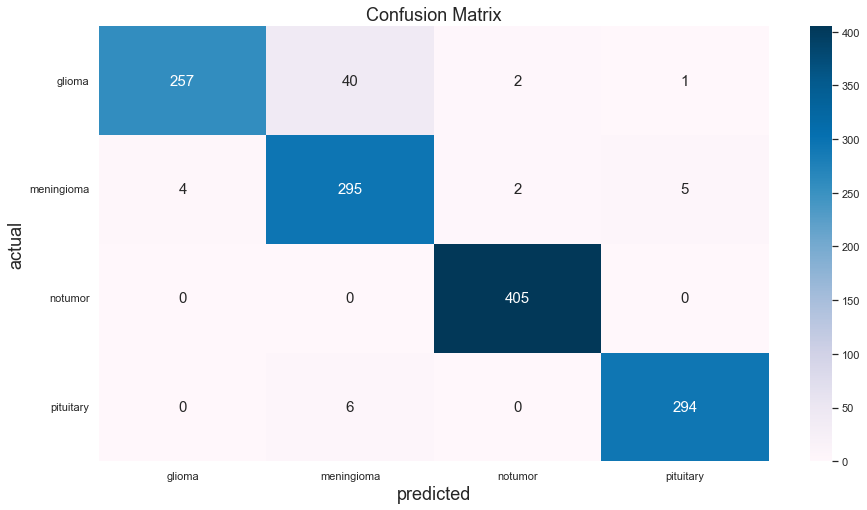

In [140]:
evaluation(y_true, y_pred_vgg16)

In [ ]:
# {0"'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary'}

In [150]:
tf.keras.models.save_model(model_vgg16,'model_vgg16.hdf5')

#### Inception_v3 with ImageNet weights

In [65]:
from keras.applications.inception_v3 import InceptionV3

inceptionv3_layer = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in inceptionv3_layer.layers:
    layer.trainable = False
# Set the last vgg block to trainable
inceptionv3_layer.layers[-2].trainable = True
inceptionv3_layer.layers[-3].trainable = True
inceptionv3_layer.layers[-4].trainable = True

model_inceptionv3 = Sequential()
model_inceptionv3.add(Input(shape=(224, 224, 3)))
model_inceptionv3.add(inceptionv3_layer)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dropout(0.3))
model_inceptionv3.add(Dense(128, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(4, activation='softmax'))

In [66]:
model_inceptionv3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 28,357,028
Trainable params: 6,554,244
N

In [67]:
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['sparse_categorical_accuracy'])

In [68]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history_inceptionv3 = model_inceptionv3.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                                            epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 90s 308ms/step - loss: 0.5176 - sparse_categorical_accuracy: 0.8082
Epoch 2/4
285/285 [==============================] - 87s 306ms/step - loss: 0.2486 - sparse_categorical_accuracy: 0.9046
Epoch 3/4
285/285 [==============================] - 86s 303ms/step - loss: 0.1827 - sparse_categorical_accuracy: 0.9331
Epoch 4/4
285/285 [==============================] - 86s 303ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9536


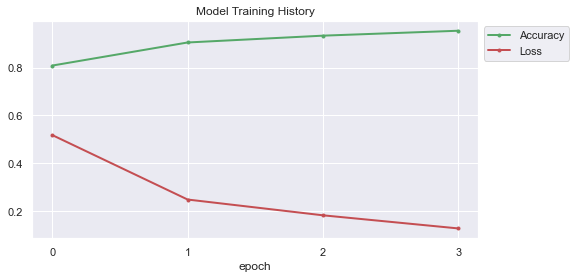

In [69]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_inceptionv3.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_inceptionv3.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

1/1 [==============================] - 0s 54ms/step
Predicted: glioma
Actual: glioma


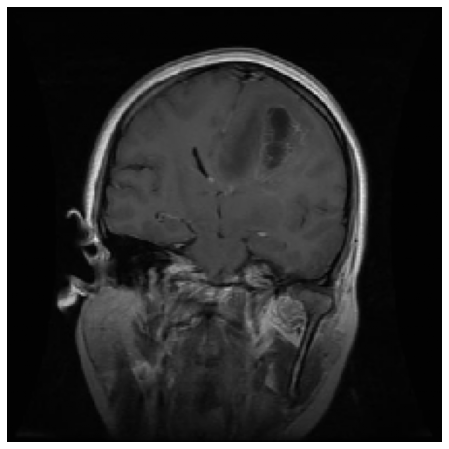

In [80]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted_iv3 = model_inceptionv3.predict(images)[0]
predicted_iv3 = np.argmax(predicted_iv3)
predicted_iv3 = labels[predicted_iv3]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
plt.axis('off')
print('Predicted:', predicted_iv3)
print('Actual:', label)

In [81]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_iv3 = []
y_true = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_iv3 = model_inceptionv3.predict(x)
    pred_iv3 = np.argmax(pred_iv3, axis=-1)
    for i in decode_label(pred_iv3):
        y_pred_iv3.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 0s 422ms/step


  2%|██                                                                                 | 1/40 [00:00<00:21,  1.85it/s]

1/1 [==============================] - 0s 432ms/step


  5%|████▏                                                                              | 2/40 [00:01<00:20,  1.85it/s]

1/1 [==============================] - 0s 418ms/step


  8%|██████▏                                                                            | 3/40 [00:01<00:19,  1.87it/s]

1/1 [==============================] - 0s 422ms/step


 10%|████████▎                                                                          | 4/40 [00:02<00:19,  1.89it/s]

1/1 [==============================] - 0s 428ms/step


 12%|██████████▍                                                                        | 5/40 [00:02<00:18,  1.87it/s]

1/1 [==============================] - 0s 416ms/step


 15%|████████████▍                                                                      | 6/40 [00:03<00:18,  1.87it/s]

1/1 [==============================] - 0s 428ms/step


 18%|██████████████▌                                                                    | 7/40 [00:03<00:17,  1.88it/s]

1/1 [==============================] - 0s 413ms/step


 20%|████████████████▌                                                                  | 8/40 [00:04<00:16,  1.89it/s]

1/1 [==============================] - 0s 418ms/step


 22%|██████████████████▋                                                                | 9/40 [00:04<00:16,  1.90it/s]

1/1 [==============================] - 0s 417ms/step


 25%|████████████████████▌                                                             | 10/40 [00:05<00:15,  1.90it/s]

1/1 [==============================] - 0s 426ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:05<00:15,  1.90it/s]

1/1 [==============================] - 0s 447ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:06<00:14,  1.88it/s]

1/1 [==============================] - 0s 419ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:06<00:14,  1.88it/s]

1/1 [==============================] - 0s 444ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:07<00:13,  1.86it/s]

1/1 [==============================] - 0s 429ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:07<00:13,  1.86it/s]

1/1 [==============================] - 0s 454ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:08<00:13,  1.83it/s]

1/1 [==============================] - 0s 445ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:09<00:12,  1.82it/s]

1/1 [==============================] - 0s 442ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:09<00:12,  1.82it/s]

1/1 [==============================] - 0s 430ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:10<00:11,  1.83it/s]

1/1 [==============================] - 0s 428ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:10<00:10,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:11<00:10,  1.86it/s]

1/1 [==============================] - 0s 418ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:11<00:09,  1.86it/s]

1/1 [==============================] - 0s 442ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:12<00:09,  1.86it/s]

1/1 [==============================] - 0s 442ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:12<00:08,  1.86it/s]

1/1 [==============================] - 0s 429ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:13<00:08,  1.84it/s]

1/1 [==============================] - 0s 416ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:13<00:07,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:14<00:07,  1.84it/s]

1/1 [==============================] - 0s 415ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:15<00:06,  1.83it/s]

1/1 [==============================] - 0s 422ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:15<00:05,  1.86it/s]

1/1 [==============================] - 0s 417ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:16<00:05,  1.86it/s]

1/1 [==============================] - 0s 441ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:16<00:04,  1.85it/s]

1/1 [==============================] - 0s 410ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:17<00:04,  1.86it/s]

1/1 [==============================] - 0s 418ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:17<00:03,  1.88it/s]

1/1 [==============================] - 0s 422ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:18<00:03,  1.89it/s]

1/1 [==============================] - 0s 422ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:18<00:02,  1.89it/s]

1/1 [==============================] - 0s 452ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:19<00:02,  1.87it/s]

1/1 [==============================] - 0s 434ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:19<00:01,  1.86it/s]

1/1 [==============================] - 0s 423ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:20<00:01,  1.88it/s]

1/1 [==============================] - 0s 446ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:20<00:00,  1.84it/s]

1/1 [==============================] - 0s 466ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]

1/1 [==============================] - 0s 435ms/step


41it [00:22,  1.86it/s]                                                                                                


In [82]:
print(classification_report(y_true, y_pred_iv3))

              precision    recall  f1-score   support

      glioma       0.99      0.70      0.82       300
  meningioma       0.76      0.94      0.84       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.91      1311
   macro avg       0.92      0.90      0.90      1311
weighted avg       0.92      0.91      0.91      1311



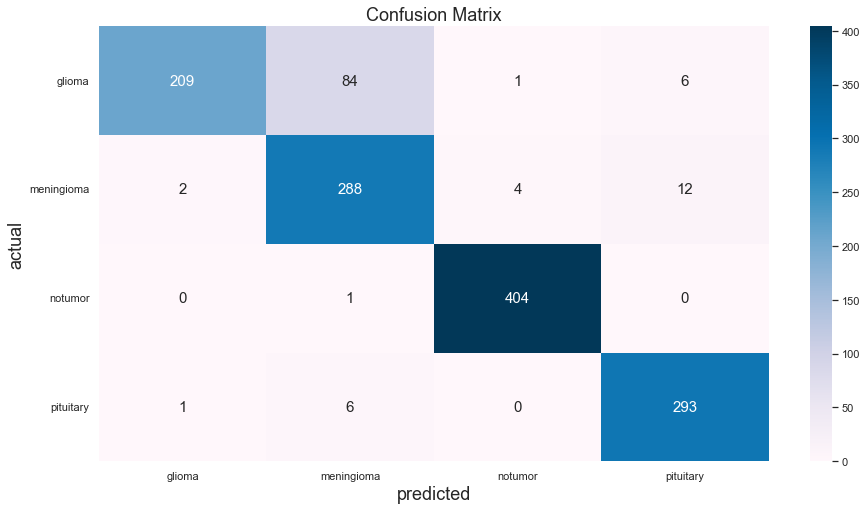

In [83]:
evaluation(y_true, y_pred_iv3)

#### ResNet50

In [84]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50_layer = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in resnet50_layer.layers:
    layer.trainable = False
# Set the last vgg block to trainable
resnet50_layer.layers[-2].trainable = True
resnet50_layer.layers[-3].trainable = True
resnet50_layer.layers[-4].trainable = True

model_resnet50 = Sequential()
model_resnet50.add(Input(shape=(224, 224, 3)))
model_resnet50.add(resnet50_layer)
model_resnet50.add(Flatten())
model_resnet50.add(Dropout(0.3))
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(4, activation='softmax'))

In [85]:
model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_4 (Dropout)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               12845184  
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 13,900,420


In [86]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['sparse_categorical_accuracy'])

In [87]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history_resnet50 = model_resnet50.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                                        epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 169s 585ms/step - loss: 0.8560 - sparse_categorical_accuracy: 0.6472
Epoch 2/4
285/285 [==============================] - 163s 574ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.7245
Epoch 3/4
285/285 [==============================] - 163s 570ms/step - loss: 0.6008 - sparse_categorical_accuracy: 0.7470
Epoch 4/4
285/285 [==============================] - 165s 578ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.7723


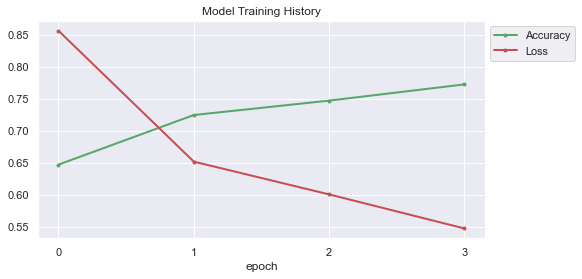

In [88]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history_resnet50.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history_resnet50.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

1/1 [==============================] - 0s 68ms/step
Predicted: glioma
Actual: glioma


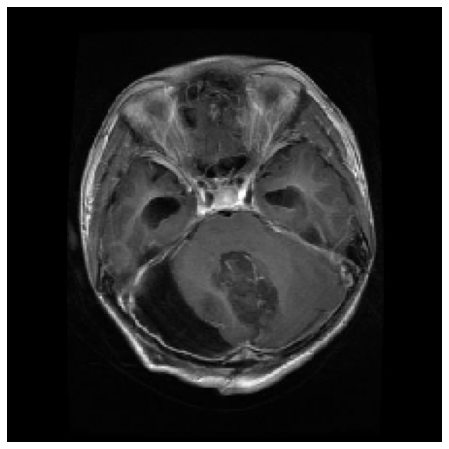

In [91]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted_rn50 = model_resnet50.predict(images)[0]
predicted_rn50 = np.argmax(predicted_rn50)
predicted_rn50 = labels[predicted_rn50]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
plt.axis('off')
print('Predicted:', predicted_rn50)
print('Actual:', label)

In [92]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred_rn50 = []
y_true = []
for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred_rn50 = model_resnet50.predict(x)
    pred_rn50 = np.argmax(pred_rn50, axis=-1)
    for i in decode_label(pred_rn50):
        y_pred_rn50.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 832ms/step


  2%|██                                                                                 | 1/40 [00:00<00:36,  1.08it/s]

1/1 [==============================] - 1s 802ms/step


  5%|████▏                                                                              | 2/40 [00:01<00:34,  1.09it/s]

1/1 [==============================] - 1s 798ms/step


  8%|██████▏                                                                            | 3/40 [00:02<00:33,  1.10it/s]

1/1 [==============================] - 1s 792ms/step


 10%|████████▎                                                                          | 4/40 [00:03<00:32,  1.11it/s]

1/1 [==============================] - 1s 783ms/step


 12%|██████████▍                                                                        | 5/40 [00:04<00:31,  1.11it/s]

1/1 [==============================] - 1s 799ms/step


 15%|████████████▍                                                                      | 6/40 [00:05<00:30,  1.11it/s]

1/1 [==============================] - 1s 818ms/step


 18%|██████████████▌                                                                    | 7/40 [00:06<00:29,  1.10it/s]

1/1 [==============================] - 1s 778ms/step


 20%|████████████████▌                                                                  | 8/40 [00:07<00:28,  1.11it/s]

1/1 [==============================] - 1s 795ms/step


 22%|██████████████████▋                                                                | 9/40 [00:08<00:27,  1.11it/s]

1/1 [==============================] - 1s 829ms/step


 25%|████████████████████▌                                                             | 10/40 [00:09<00:27,  1.10it/s]

1/1 [==============================] - 1s 821ms/step


 28%|██████████████████████▌                                                           | 11/40 [00:09<00:26,  1.09it/s]

1/1 [==============================] - 1s 813ms/step


 30%|████████████████████████▌                                                         | 12/40 [00:10<00:25,  1.09it/s]

1/1 [==============================] - 1s 868ms/step


 32%|██████████████████████████▋                                                       | 13/40 [00:11<00:25,  1.07it/s]

1/1 [==============================] - 1s 801ms/step


 35%|████████████████████████████▋                                                     | 14/40 [00:12<00:24,  1.08it/s]

1/1 [==============================] - 1s 799ms/step


 38%|██████████████████████████████▊                                                   | 15/40 [00:13<00:23,  1.09it/s]

1/1 [==============================] - 1s 786ms/step


 40%|████████████████████████████████▊                                                 | 16/40 [00:14<00:21,  1.10it/s]

1/1 [==============================] - 1s 801ms/step


 42%|██████████████████████████████████▊                                               | 17/40 [00:15<00:20,  1.10it/s]

1/1 [==============================] - 1s 807ms/step


 45%|████████████████████████████████████▉                                             | 18/40 [00:16<00:19,  1.11it/s]

1/1 [==============================] - 1s 799ms/step


 48%|██████████████████████████████████████▉                                           | 19/40 [00:17<00:19,  1.10it/s]

1/1 [==============================] - 1s 798ms/step


 50%|█████████████████████████████████████████                                         | 20/40 [00:18<00:18,  1.10it/s]

1/1 [==============================] - 1s 797ms/step


 52%|███████████████████████████████████████████                                       | 21/40 [00:19<00:17,  1.10it/s]

1/1 [==============================] - 1s 818ms/step


 55%|█████████████████████████████████████████████                                     | 22/40 [00:20<00:16,  1.10it/s]

1/1 [==============================] - 1s 799ms/step


 57%|███████████████████████████████████████████████▏                                  | 23/40 [00:20<00:15,  1.10it/s]

1/1 [==============================] - 1s 802ms/step


 60%|█████████████████████████████████████████████████▏                                | 24/40 [00:21<00:14,  1.10it/s]

1/1 [==============================] - 1s 825ms/step


 62%|███████████████████████████████████████████████████▎                              | 25/40 [00:22<00:13,  1.09it/s]

1/1 [==============================] - 1s 829ms/step


 65%|█████████████████████████████████████████████████████▎                            | 26/40 [00:23<00:12,  1.09it/s]

1/1 [==============================] - 1s 817ms/step


 68%|███████████████████████████████████████████████████████▎                          | 27/40 [00:24<00:11,  1.09it/s]

1/1 [==============================] - 1s 857ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 28/40 [00:25<00:11,  1.07it/s]

1/1 [==============================] - 1s 804ms/step


 72%|███████████████████████████████████████████████████████████▍                      | 29/40 [00:26<00:10,  1.08it/s]

1/1 [==============================] - 1s 792ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 30/40 [00:27<00:09,  1.08it/s]

1/1 [==============================] - 1s 849ms/step


 78%|███████████████████████████████████████████████████████████████▌                  | 31/40 [00:28<00:08,  1.08it/s]

1/1 [==============================] - 1s 802ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 32/40 [00:29<00:07,  1.08it/s]

1/1 [==============================] - 1s 808ms/step


 82%|███████████████████████████████████████████████████████████████████▋              | 33/40 [00:30<00:06,  1.09it/s]

1/1 [==============================] - 1s 827ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 34/40 [00:31<00:05,  1.08it/s]

1/1 [==============================] - 1s 805ms/step


 88%|███████████████████████████████████████████████████████████████████████▊          | 35/40 [00:32<00:04,  1.09it/s]

1/1 [==============================] - 1s 813ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 36/40 [00:32<00:03,  1.09it/s]

1/1 [==============================] - 1s 782ms/step


 92%|███████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:33<00:02,  1.10it/s]

1/1 [==============================] - 1s 798ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 38/40 [00:34<00:01,  1.10it/s]

1/1 [==============================] - 1s 817ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:35<00:00,  1.10it/s]

1/1 [==============================] - 1s 823ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:36<00:00,  1.09it/s]

1/1 [==============================] - 1s 805ms/step


41it [00:37,  1.09it/s]                                                                                                


In [93]:
print(classification_report(y_true, y_pred_rn50))

              precision    recall  f1-score   support

      glioma       0.80      0.45      0.58       300
  meningioma       0.55      0.46      0.50       306
     notumor       0.86      0.92      0.89       405
   pituitary       0.66      0.99      0.79       300

    accuracy                           0.72      1311
   macro avg       0.72      0.71      0.69      1311
weighted avg       0.73      0.72      0.70      1311



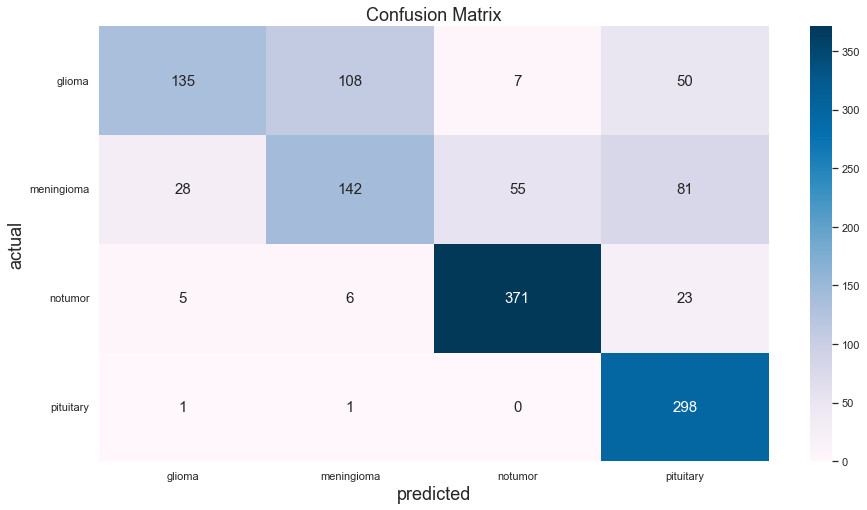

In [94]:
evaluation(y_true, y_pred_rn50)